In [1]:
# sklearn
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
import peakutils
import neurokit2 as nk
import scipy.signal as signal
import pywt
import heartpy as hp


# utils
from tqdm import tqdm

In [2]:
def score(y_true, y_hat):
    F1 = f1_score(y_true, y_hat, average='micro')
    return F1

# Load Data

In [4]:
df_train = pd.read_csv('X_train.csv', index_col='id')
df_train['y'] = pd.read_csv('y_train.csv', index_col='id').values
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841,y
id,,,,,,,,,,,,,,,,,,,,,
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [5]:
df_test = pd.read_csv('X_test.csv', index_col='id')
df_test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,30,29,28,27,26,24,24,28,38,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-75,-72,-70,-67,-64,-61,-59,-56,-53,-51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,264,280,289,293,298,302,306,308,309,310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-377,-380,-383,-385,-388,-391,-394,-397,-400,-402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-69,-67,-66,-65,-65,-66,-68,-70,-73,-76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_train, df_val = train_test_split(df_train, stratify=df_train['y'], random_state=0)
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841,y
id,,,,,,,,,,,,,,,,,,,,,
514,4,9,30,85,158,238,313,376,394,401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3054,-7,-1,4,8,10,7,2,-3,-10,-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3485,-7,-11,-12,-10,-3,4,10,19,26,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
649,3,5,7,8,9,9,10,11,13,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
185,-52,-45,-39,-35,-33,-31,-30,-30,-29,-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [7]:
print(f'Train shape: {df_train.shape}\nValidation shape: {df_val.shape}\nTest shape: {df_test.shape}')

Train shape: (3837, 17843)
Validation shape: (1280, 17843)
Test shape: (3411, 17842)


# Explore data

<AxesSubplot:>

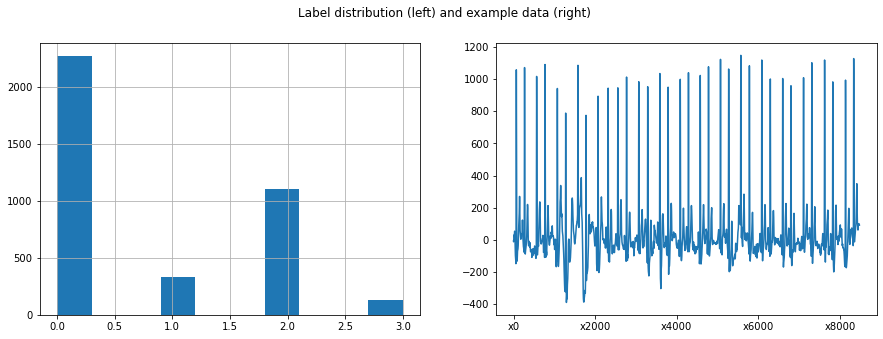

In [8]:
# Plot label Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Label distribution (left) and example data (right)')
df_train['y'].hist(ax=axes[0])
df_train.iloc[2, :-2].plot(ax=axes[1])

In [9]:
df_train['y'].value_counts()/len(df_train['y'])*100

0    59.212927
2    28.798541
1     8.652593
3     3.335940
Name: y, dtype: float64

In [10]:
df_train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841,y
count,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3837.000000
mean,4.838415,3.852228,3.068543,2.399792,2.143341,2.528538,3.126922,3.702893,4.453740,5.305708,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,0.762575
std,339.591322,338.418022,337.598593,338.130694,339.613389,342.265429,345.922125,349.737888,353.229867,356.758749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978484
min,-5888.000000,-5849.000000,-5750.000000,-5638.000000,-5515.000000,-5379.000000,-5233.000000,-5168.000000,-5760.000000,-6279.000000,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,0.000000
25%,-91.000000,-91.000000,-91.000000,-90.000000,-89.000000,-88.000000,-86.000000,-86.000000,-87.000000,-87.000000,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,0.000000
50%,-9.000000,-10.000000,-11.000000,-10.000000,-10.000000,-10.000000,-9.000000,-8.000000,-9.000000,-9.000000,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,0.000000
75%,86.000000,85.000000,84.000000,83.000000,85.000000,85.000000,84.000000,84.000000,83.000000,83.000000,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,2.000000
max,5471.000000,5487.000000,5470.000000,5452.000000,5437.000000,5432.000000,5431.000000,5429.000000,5427.000000,5410.000000,...,-120.0,-118.0,-116.0,-115.0,-114.0,-113.0,-112.0,-111.0,NaN,3.000000


In [11]:
df_train[df_train['y'] == 3]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841,y
id,,,,,,,,,,,,,,,,,,,,,
818,17,23,24,21,19,17,14,14,21,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2948,-59,-37,-16,6,31,58,86,114,159,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2839,-93,-40,314,353,390,455,446,293,140,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3160,193,199,205,211,216,220,223,224,224,223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3267,-164,-162,-161,-160,-160,-159,-158,-156,-154,-151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4980,280,264,249,234,219,200,176,152,127,102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3290,-199,-195,-192,-188,-183,-174,-163,-153,-142,-132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1075,237,239,242,245,249,252,255,259,263,268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


# Explore and extract single beats

1.0


/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


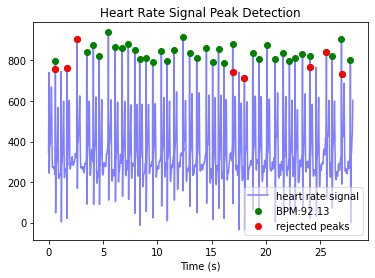

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])
Dirty beats are 18.604651%
 number of clean beats in signal 25 out of 42


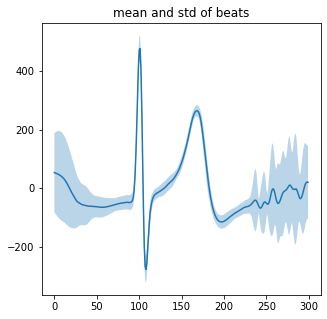

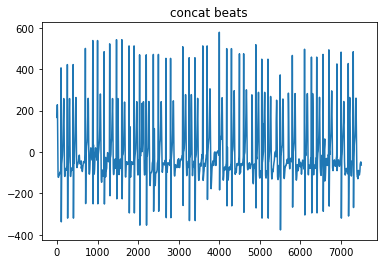

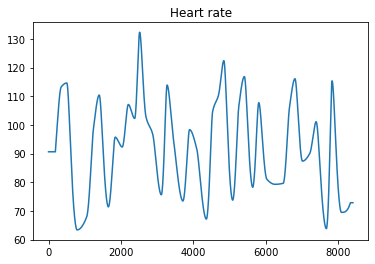

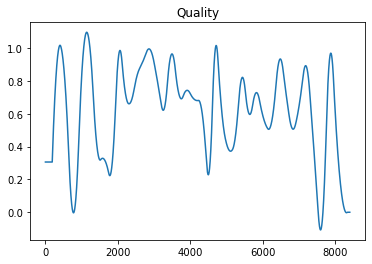

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,label,idx
0,167.0,177.0,186.0,194.0,200.0,206.0,212.0,218.0,223.0,227.0,...,-3.0,1.0,6.0,11.0,16.0,21.0,26.0,32.0,1.0,0
1,162.0,176.0,190.0,204.0,218.0,230.0,238.0,244.0,249.0,254.0,...,-47.0,-46.0,-46.0,-45.0,-45.0,-44.0,-43.0,-43.0,1.0,0
2,-79.0,-79.0,-78.0,-77.0,-76.0,-74.0,-73.0,-72.0,-71.0,-70.0,...,-245.0,-203.0,-157.0,-118.0,-90.0,-72.0,-53.0,-36.0,1.0,0
3,35.0,1.0,-18.0,-40.0,-60.0,-75.0,-84.0,-91.0,-96.0,-100.0,...,-39.0,-36.0,-34.0,-32.0,-30.0,-29.0,-28.0,-26.0,1.0,0
4,-120.0,-110.0,-101.0,-96.0,-94.0,-92.0,-91.0,-90.0,-89.0,-89.0,...,-13.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-11.0,1.0,0
5,254.0,256.0,258.0,255.0,248.0,238.0,222.0,207.0,191.0,166.0,...,-43.0,-39.0,-37.0,-35.0,-32.0,-29.0,-25.0,-22.0,1.0,0
6,122.0,89.0,58.0,28.0,0.0,-26.0,-52.0,-68.0,-85.0,-100.0,...,134.0,152.0,169.0,186.0,200.0,214.0,227.0,235.0,1.0,0
7,2.0,3.0,6.0,10.0,15.0,21.0,27.0,34.0,40.0,45.0,...,-63.0,-59.0,-56.0,-52.0,-48.0,-41.0,-31.0,-23.0,1.0,0
8,113.0,83.0,53.0,24.0,-1.0,-25.0,-40.0,-57.0,-71.0,-82.0,...,-259.0,-311.0,-317.0,-298.0,-249.0,-194.0,-147.0,-107.0,1.0,0
9,-50.0,-61.0,-76.0,-84.0,-87.0,-90.0,-92.0,-94.0,-95.0,-96.0,...,-38.0,-37.0,-36.0,-34.0,-33.0,-33.0,-32.0,-32.0,1.0,0


In [12]:
idx = 0
#ecg = df_train.loc[2948, :].iloc[:]
ecg = df_train.iloc[idx, :]
fil = ~ecg.isna()
ecg = ecg[fil]
label = ecg[-1]
print(label)
ecg = ecg[:-1]

import heartpy as hp

working_data, measures = hp.process(ecg.values, 300.0)
hp.plotter(working_data, measures)
plt.show()

num_dirty = len(working_data['removed_beats'])
num_clean = len(working_data['peaklist'])


print(working_data.keys())
# Process it
signals, info = nk.ecg_process(ecg.values, sampling_rate=300)
quality_t = 0.6
before = 100
after = 200

beats = []
for peak_idx in info['ECG_R_Peaks']:
    beat = ecg[peak_idx-before:peak_idx+after].values
    if signals['ECG_Quality'].iloc[peak_idx] > quality_t: 
        if (len(beat) == before + after):
            beats.append(beat)

num_beats = len(info['ECG_R_Peaks'])

print(f'Dirty beats are {num_dirty/num_clean*100:3f}%')
print(f' number of clean beats in signal {len(beats)} out of {num_beats}')
df = pd.DataFrame(beats)
df['label'] = label

mean = np.mean(beats, axis=0)
std = np.std(beats, axis=0)

# plots
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
ax.plot(mean)
ax.fill_between(range(before+after), mean-std, mean + std, alpha=0.3)
plt.title('mean and std of beats')
plt.show()

beat_signal = np.array(beats).flatten()
plt.plot(beat_signal)
plt.title('concat beats')
plt.show()

signals['ECG_Rate'].plot()
plt.title('Heart rate')
plt.show()

signals['ECG_Quality'].plot()
plt.title('Quality')
plt.show()

df['idx'] = idx
df

In [22]:
dfs = []
#ecg = df_train.loc[2948, :].iloc[:]
def extract_beats(data):
    for idx in tqdm(range(len(data))):
        ecg = data.iloc[idx, :]
        fil = ~ecg.isna()
        ecg = ecg[fil]
        label = ecg[-1]
        ecg = ecg[:-1]

        try:
            working_data, measures = hp.process(ecg.values, 300.0)
        except:
            continue

        num_dirty = len(working_data['removed_beats'])
        num_clean = len(working_data['peaklist'])

        # Process it
        try:
            signals, info = nk.ecg_process(ecg.values, sampling_rate=300)
        except:
            continue

        before = 100
        after = 200

        beats = []
        for peak_idx in info['ECG_R_Peaks']:
            beat = ecg[peak_idx-before:peak_idx+after].values
            if (len(beat) == before + after):
                beats.append(beat)

        num_beats = len(info['ECG_R_Peaks'])
        df = pd.DataFrame(beats)
        df['label'] = label
        df['idx'] = idx
        df['dirty_peak_ratio'] = num_dirty/num_clean
        df['Quality'] = signals['ECG_Quality'].iloc[peak_idx]
        dfs.append(df)
        
    # normalize
    df_beats = pd.concat(dfs)
    return df_beats

train_beats = extract_beats(df_train)
train_beats.to_csv('train_beats.csv')

val_beats = extract_beats(df_val)
val_beats.to_csv('val_beats.csv')

test_beats = extract_beats(df_test)
test_beats.to_csv('test_beats.csv')

  0%|          | 0/3411 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
  0%|          | 14/3411 [00:02<11:33,  4.90it/s]/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
  0%|          | 15/3411 [00:02<10:57,  5.17it/s]/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/numpy/ma/core.py:5239: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/opt/homebrew/Caskroom/miniforge/base/envs/a

# Extract class 3

In [186]:
qualities =[[], [], [], []]
import heartpy as hp

for idx in range(len(df_train)):
    #ecg = df_train.loc[2948, :].iloc[:]
    ecg = df_train.iloc[idx, :]
    fil = ~ecg.isna()
    ecg = ecg[fil]
    label = int(ecg[-1])
    ecg = ecg[:-1]

    try:
        working_data, measures = hp.process(ecg.values, 300.0)
    except:
        continue

        
    num_dirty = len(working_data['removed_beats'])
    num_clean = len(working_data['peaklist'])

    qualities[label].append(num_dirty/num_clean)

for c in qualities:
    print(np.mean(c))

/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/numpy/ma/core.py:5239: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/opt/homebrew/Caskroom/miniforge/base/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  retu

0.18690815540125671
0.18215632883441266
0.18665035196550972
0.41648799669659897


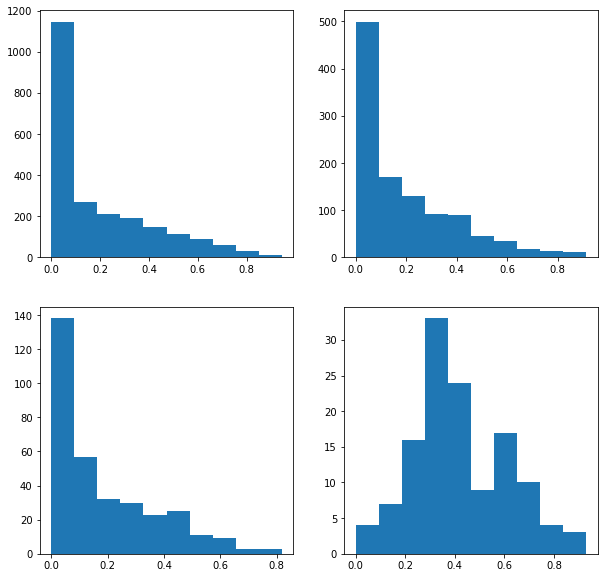

In [193]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for i, c in enumerate(qualities):
    row = i % 2
    col = i // 2
    ax[row, col].hist(c)
plt.show()

# Explore Beats

In [3]:
df_beats = pd.read_csv('train_beats.csv', index_col=0)
df_beats

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,label,idx,dirty_peak_ratio,Quality
0,190.0,163.0,132.0,101.0,73.0,53.0,34.0,15.0,-4.0,-24.0,...,-20.0,-17.0,-14.0,-10.0,-5.0,0.0,1.0,0,0.186047,0.000000
1,167.0,177.0,186.0,194.0,200.0,206.0,212.0,218.0,223.0,227.0,...,6.0,11.0,16.0,21.0,26.0,32.0,1.0,0,0.186047,0.000000
2,162.0,176.0,190.0,204.0,218.0,230.0,238.0,244.0,249.0,254.0,...,-46.0,-45.0,-45.0,-44.0,-43.0,-43.0,1.0,0,0.186047,0.000000
3,-55.0,-55.0,-54.0,-53.0,-51.0,-50.0,-49.0,-48.0,-47.0,-46.0,...,-91.0,-89.0,-87.0,-85.0,-83.0,-81.0,1.0,0,0.186047,0.000000
4,-79.0,-79.0,-78.0,-77.0,-76.0,-74.0,-73.0,-72.0,-71.0,-70.0,...,-157.0,-118.0,-90.0,-72.0,-53.0,-36.0,1.0,0,0.186047,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,-86.0,-85.0,-84.0,-82.0,-80.0,-78.0,-77.0,-77.0,-77.0,-77.0,...,-66.0,-64.0,-62.0,-60.0,-59.0,-58.0,0.0,3836,0.253012,0.761767
24,-75.0,-73.0,-72.0,-70.0,-69.0,-69.0,-67.0,-66.0,-64.0,-62.0,...,-57.0,-56.0,-56.0,-56.0,-55.0,-55.0,0.0,3836,0.253012,0.761767
25,-57.0,-56.0,-56.0,-56.0,-55.0,-55.0,-54.0,-52.0,-51.0,-50.0,...,-124.0,-120.0,-116.0,-112.0,-108.0,-103.0,0.0,3836,0.253012,0.761767
26,0.0,11.0,21.0,29.0,36.0,45.0,55.0,68.0,83.0,94.0,...,-110.0,-111.0,-111.0,-111.0,-110.0,-110.0,0.0,3836,0.253012,0.761767


In [4]:
df_beats.groupby('label').count()['idx']

label
0.0    77548
1.0    14628
2.0    42503
3.0     3150
Name: idx, dtype: int64

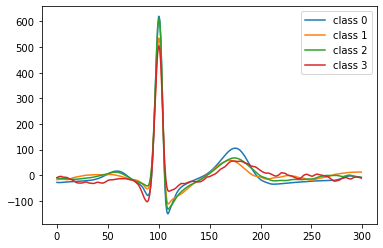

In [5]:
for T in [0]:
    m = df_beats[df_beats['Quality'] > T].groupby('label').mean().iloc[:, :-3].values

    for i, mi in enumerate(m):
        plt.plot(mi, label=f'class {i}')

    plt.legend()
    plt.show()

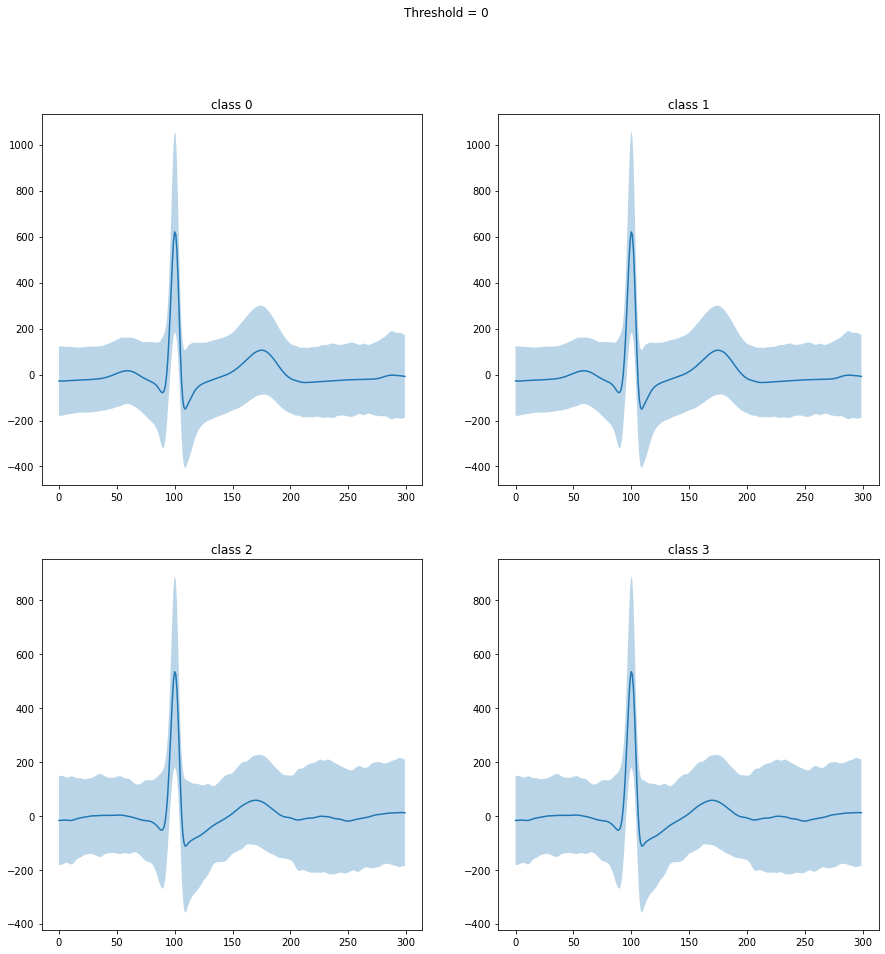

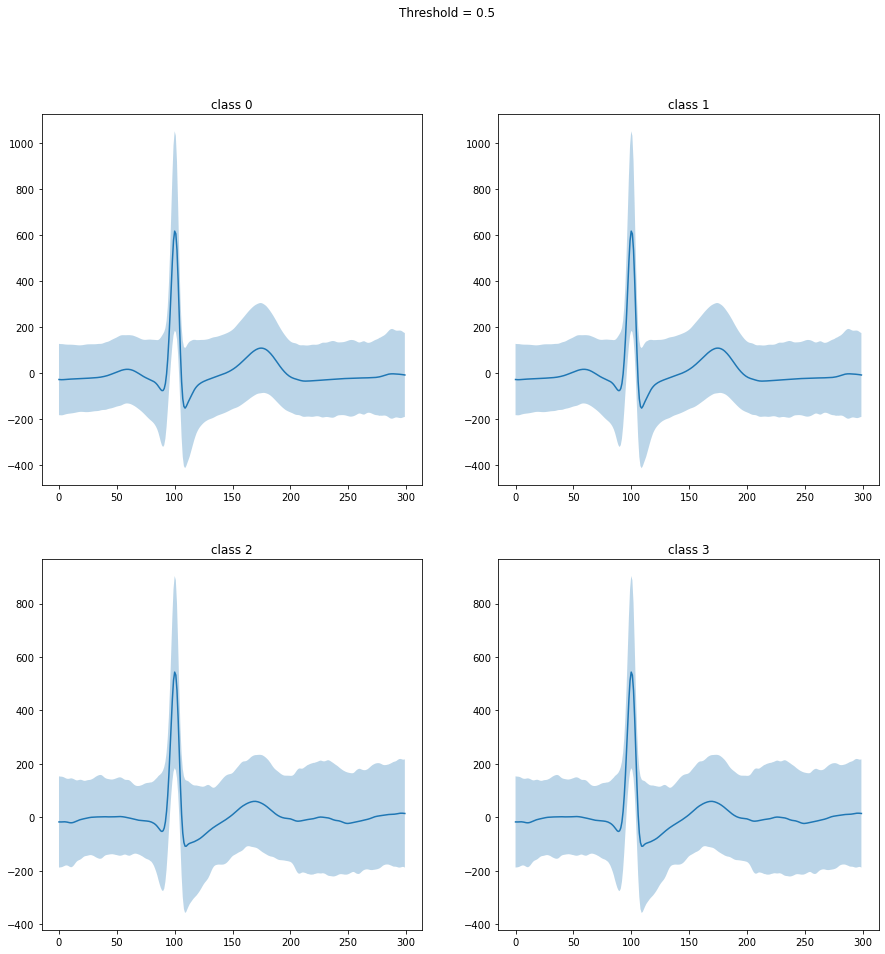

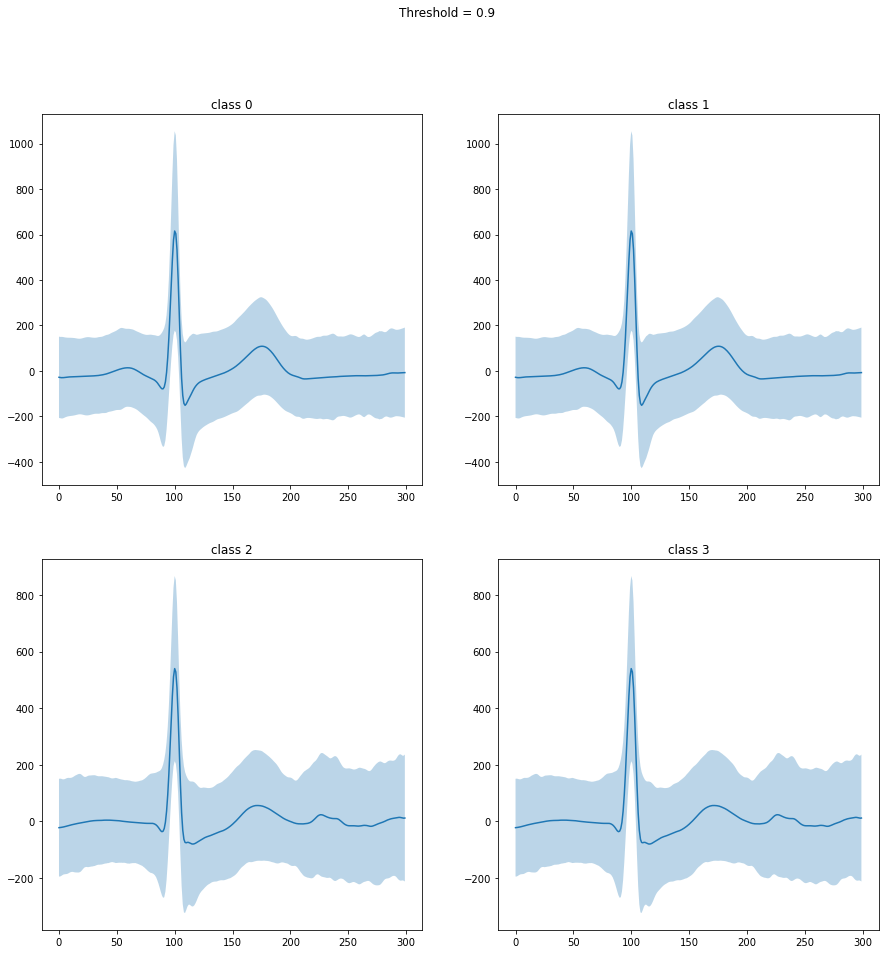

In [6]:
for T in [0, 0.5, 0.9]:
    mean = df_beats[df_beats['Quality'] > T].groupby('label').mean().iloc[:, :-3].values
    std = df_beats[df_beats['Quality'] > T].groupby('label').std().iloc[:, :-3].values

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    fig.suptitle(f'Threshold = {T}')
    for i in range(2):
        for j in range(2):
            ax[i, j].set_title(f'class {i*2 + j}')
            ax[i, j].plot(mean[i])
            ax[i, j].fill_between(range(300), mean[i]-std[i], mean[i] + std[i], alpha=0.3)

    plt.show()

# Baselines

In [177]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(df_train.fillna(0).iloc[:, :3000], df_train.fillna(0)['y'], test_size=0.2)



In [178]:
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train, y_train)
y_hat = svc.predict(X_test)

In [179]:
score(y_test, y_hat)

0.3997395833333333

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_train_norm.fillna(0).iloc[:, :3000], df_train.fillna(0)['y'], test_size=0.2)
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train, y_train)
y_hat = svc.predict(X_test)
score(y_test, y_hat)

0.431640625

In [39]:
y_hat = svc.predict(X_train)
score(y_train, y_hat), 'train score'

(0.683606156853164, 'train score')

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df_beats.iloc[:, :-2].values, df_beats.iloc[:, -2].values, test_size=0.2, shuffle=True)
print(X_train.shape)
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train, y_train)
y_hat = svc.predict(X_test)
score(y_test, y_hat)

(24000, 60)


ValueError: The number of classes has to be greater than one; got 1 class

# LSTM Code

In [2]:
import torch

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F

from tqdm import trange


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = 'cpu'

def create_dataset(df):
    sequence = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequence]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

df_beats = pd.read_csv('train_beats.csv', index_col=0)
df_beats_clean = df_beats[df_beats['Quality'] > 0.99]

df_beats_clean.iloc[:, :-4] = df_beats_clean.iloc[:, :-4]/1000


train_beats, val_beats = train_test_split(df_beats_clean.iloc[:, :-3], test_size=0.3)
val_beats, test_beats = train_test_split(val_beats, test_size=0.5)

CLASS = 0

train_dataset, seq_len, n_features = create_dataset(train_beats[train_beats['label'] == CLASS].iloc[:, :-1])
val_dataset, _, _ = create_dataset(val_beats[val_beats['label'] == CLASS].iloc[:, :-1])
test_normal_dataset, _, _ = create_dataset(test_beats[test_beats['label'] == CLASS].iloc[:, :-1])
test_anomaly_dataset, _, _ = create_dataset(test_beats.iloc[:, :-1])


class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))


class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)



class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x


model = RecurrentAutoencoder(seq_len, n_features, 64)
model = model.to(device)



def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    t = trange(len(train_dataset))
    t.set_description(desc=f'Epoch: {epoch}')

    for i in t:
      seq_true = train_dataset[i]
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)
      

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
      t.set_postfix(loss=f'{np.mean(train_losses)}')

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history



model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)


MODEL_PATH = f'model_{CLASS}.pth'
torch.save(model, MODEL_PATH)


fig, ax = plt.subplots(ncols=1, nrows=1)

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

In [ ]:
THRESHOLD = 26

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')